### Diffusion Equation (1D) using Devito

$$
  \frac{du}{dt} = D \frac{d^2u}{dx^2}   x\in(0,L), t\in(0,T]
$$

Example

Initial concentration:
$$
u(x,0) = \frac{1}{\sigma \sqrt{2 \pi}} \exp(- \frac{(x-x_{mean})^2}{\sigma ^2})
$$



In [1]:
import numpy as np
def initial_concent(x, x_mean=0.5, sigma=0.2):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp((x-x_mean)**2/-(sigma**2))

In [2]:
L = 1
dx = 0.01
x = np.arange(0, L, dx)
u0 = initial_concent(x)

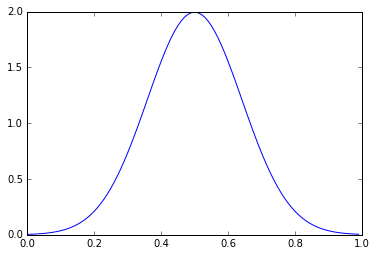

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x,u0,'b')

Discretization
$$
\frac{u_i^{n+1} - u_i^n}{\delta t} = D \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\delta x^2} 
$$


$$
u_i^{n+1} = u_i^n  + C  (u_{i+1}^n - 2u_i^n + u_{i-1}^n)
$$

$$
C = D \frac{\delta t}{\delta x^2}
$$

In [4]:
a=0.5
spacing = 0.01
dx2, dy2 = spacing**2, spacing**2
dt = dx2 * dy2 / (2 * a * (dx2 + dy2))

In [5]:
from devito import TimeData, Operator
from sympy import Eq, solve
from sympy.abc import h, s

D = 1.0
Nx = len(x)
dt = 0.00001
Nt1 = 1000

#initial condition
u0 = initial_concent(x)

# Allocate the grid and set initial condition
# Note: This should be made simpler through the use of defaults
u = TimeData(name='u', shape=(Nx, ), time_order=1, space_order=2, time_dim=Nt1, save=True)
u.data[0, :] = u0[:]

In [6]:
# Derive the stencil according to devito conventions
eqn = Eq(u.dt, D * u.dx2)
stencil = solve(eqn, u.forward)[0]
op = Operator([Eq(u.forward, stencil)], subs={h: dx, s: dt})

# Execute the generated Devito stencil operator
op.apply(u=u)

DSE: <filter object at 0x11354af28> [flops: 5, elapsed: 0.00] >>
     <filter object at 0x11354af28> [flops: 5, elapsed: 0.00] >>
     <filter object at 0x11354af28> [flops: 5, elapsed: 0.00] >>
     <filter object at 0x11354af28> [flops: 4, elapsed: 0.00] >>
     <filter object at 0x11354af28> [flops: 4, elapsed: 0.00]
     [Total elapsed: 0.01 s]
DLE: <filter object at 0x113594208> [elapsed: 0.00] >>
     <filter object at 0x113594eb8> [elapsed: 0.00] >>
     <filter object at 0x113594208> [elapsed: 0.00] >>
     <filter object at 0x113594eb8> [elapsed: 0.00] >>
     <filter object at 0x113594208> [elapsed: 0.00] >>
     <filter object at 0x113594d68> [elapsed: 0.01]
     [Total elapsed: 0.03 s]
ClangCompiler: compiled /var/folders/f3/c2wg4lkx1ms7_41c3qzz8x7nrdhbjw/T/devito-1893215804/8029b763fc3954d6e9f9e4e420a59e7ad5de5346.c [0.09 s]
Section main<1000,99> with OI=0.49 computed in 0.000 s [Perf: 2.69 GFlops/s]


PerformanceSummary([('main',
                     PerfEntry(time=0.000147, gflopss=2.693877551020408, oi=0.495, itershape=[1000, 99], datashape=[1000, 100]))])

In [7]:
Nt2 = 5000
u2 = TimeData(name='u', shape=(Nx, ), time_order=1, space_order=2, time_dim=Nt2, save=True)
u2.data[0, :] = u0[:]

eqn = Eq(u2.dt, D * u2.dx2)
stencil = solve(eqn, u2.forward)[0]
op = Operator([Eq(u2.forward, stencil)], subs={h: dx, s: dt})
op.apply()

DSE: <filter object at 0x113767358> [flops: 5, elapsed: 0.00] >>
     <filter object at 0x113767358> [flops: 5, elapsed: 0.00] >>
     <filter object at 0x113767358> [flops: 5, elapsed: 0.00] >>
     <filter object at 0x113767358> [flops: 4, elapsed: 0.00] >>
     <filter object at 0x113767358> [flops: 4, elapsed: 0.00]
     [Total elapsed: 0.01 s]
DLE: <filter object at 0x11398ab70> [elapsed: 0.00] >>
     <filter object at 0x11398ab70> [elapsed: 0.00] >>
     <filter object at 0x11398ab70> [elapsed: 0.00] >>
     <filter object at 0x11398ab70> [elapsed: 0.00] >>
     <filter object at 0x11398ab70> [elapsed: 0.00] >>
     <filter object at 0x11398aba8> [elapsed: 0.00]
     [Total elapsed: 0.01 s]
ClangCompiler: compiled /var/folders/f3/c2wg4lkx1ms7_41c3qzz8x7nrdhbjw/T/devito-1893215804/8029b763fc3954d6e9f9e4e420a59e7ad5de5346.c [0.09 s]
Section main<5000,99> with OI=0.49 computed in 0.001 s [Perf: 2.12 GFlops/s]


PerformanceSummary([('main',
                     PerfEntry(time=0.000932, gflopss=2.124463519313305, oi=0.495, itershape=[5000, 99], datashape=[5000, 100]))])

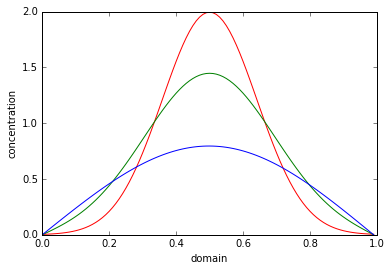

In [8]:
plt.plot(x,u0, '-r')
plt.plot(x,u.data[900,:], '-g')
plt.plot(x,u2.data[4900,:], '-b')
plt.xlabel('domain')
plt.ylabel('concentration')

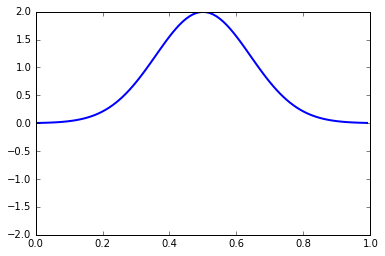

In [11]:
from matplotlib import animation

#plot the first step
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-2,2))
line, = ax.plot(x, u0, lw=2)

def do_steps(i):
    line.set_ydata(u2.data[i,:])    # update data in plot
    fig.canvas.draw()# redraw the canvas
    return line,

In [12]:
from IPython.core.display import HTML
#css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
#HTML(url=css_file)

HTML(animation.FuncAnimation(fig,do_steps, range(Nt2)).to_html5_video())